<a href="https://colab.research.google.com/github/dtee1/Foundations_of_Machine_Learning_for_Scientists_and_Engineers/blob/main/Assignment2/IAI5101_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student name: David Talson 
# Course: Foundations of ML for Engineers & Scientists
# Assignment 2

The goal of this assignment is to apply various machine learning techniques to predict the oompressive strenght of cement.

In [39]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.axisartist.axislines import Subplot
from sklearn.model_selection import train_test_split
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout

import torch
import warnings
import os
import datetime
from contextlib import redirect_stdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans


In [40]:
def load_dataset(file_name): 
  """ Load dataset

  Parameters:
  ----------
  file_name: (str): File name with extension

  Raises:
  ------
    Exception: File not found

  Returns:
  -------
  Dataset

  """
  try: 
    dataset = pd.read_csv(file_name)
    print(f"File found")
    return dataset
  except Exception as e:
    print(f"Error: {e}")
    return None

In [41]:
def exploratory_da(dataset, fig_number=1):
  """ Perform univariate or multivariate data analysis on the provided dataset

  Parameters:
  ----------
  dataset: (pandas.DataFrame): Input Dataset
  fig_number (int): Starting figure number

  Raises:
  ------
    TypeError: Dataset is not a pandas DataFrame

  Returns:
  -------
  Last figure number

  """
  if not isinstance(dataset, pd.DataFrame): 
    raise TypeError("Input dataset is not a pandas dataframe")
  
  last_fig_number = fig_number
  plt.figure(last_fig_number)
  dataset.hist(bins=10,figsize=(20,20))
  plt.show()
  last_fig_number+=1

  plt.figure(last_fig_number)
  plt.figure(figsize=(20,20))
  sns.set_style(style='whitegrid')
  col_len = dataset.shape[1]

  for col in range(col_len):
    plt.subplot(3,3,col+1)
    plt.title('Boxplot of ' + dataset.columns[col])
    sns.boxplot(x=dataset.columns[col],data=dataset)

  plt.subplots_adjust(hspace=0.5)
  last_fig_number+=1
  plt.figure(last_fig_number)
  plt.figure(figsize=(20,20))
  sns.set_style(style='whitegrid')
  sns.pairplot(dataset)
  plt.show()
  last_fig_number+=1

  plt.figure(last_fig_number)
  plt.figure(figsize=(20,20))
  sns.heatmap(dataset.corr(),annot=True)
  plt.show()
  last_fig_number+=1

  return last_fig_number


  

In [42]:
def prepare_dataset(dataset,columns,output_col):
  """ Prepare the data for downstream processes
    This is done by dropping duplicate rows and rows with missing values 
    Also, a quantile transformer is used to remove outliers in the dataset
    Then. zero values in dataset are replaced with the mean of the column
    Lastly, a standard scaler is used to normalize the dataset.

  Parameters:
  ----------
  dataset: (pandas.DataFrame): Input Dataset

  Raises:
  ------
    TypeError: Dataset is not a pandas DataFrame

  Returns:
  -------
  Proccessed Dataset

  """
  if not isinstance(dataset, pd.DataFrame): 
    raise TypeError("Input dataset is not a pandas dataframe")

  # Drop duplicate row and rows with missing values
  dataset = dataset.drop_duplicates()
  dataset = dataset.dropna(axis=0)

  # Use a Quantile Transformer to remove outliers
  quantile  = QuantileTransformer()
  dataset_new = quantile.fit_transform(dataset)
  dataset_new=pd.DataFrame(dataset_new)
  dataset_new.columns = columns

  # Check for zeros in dataset and replace with the mean of column
  for col in dataset_new.columns:
      col_mean = dataset_new[col].mean()
      dataset_new[col].replace(0, col_mean, inplace=True)
  
  # Normalize data using standard scaler 
  scaler = StandardScaler()
  dataset_scaled = scaler.fit_transform(dataset_new)
  dataset_scaled = pd.DataFrame(dataset_scaled, columns=columns)

  return dataset_scaled


# Part I: Exploratory Data Analysis



In [43]:
dataset = load_dataset('concrete.csv');
dataset.describe()

File found


,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


# Univariate and Multivariate Data Analysis
In this section, univariate and multivariate analysis are performed on the dataset. Univariate Analysis give more information on each feature while multivariate analysis show the relationship between features. 

**Univariate Analysis:**
Figures 1 and 2 below show the histogram snd box plot of each feature in the concrete dataset. From the histogram plots, we see that the Water, CoarseAggregate, CompressiveStrength, and FineAggregate features look normal as they look roughly symmetric, while the remaining features look skewed to the left. Also, from figure 2, it can be noticed that the most features contain outliers. From histogram and box plot of the age feature, it can be noticed that there are some outliers, isolated bins in the histogram and single points in the bos plot. 

**Multivariate Analysis:**
In this section, the pairplot was used to determine relationship between independent and dependent variables. The pairplot shown in figure 3 show the relationship between each feature pair. This plot makes it easy to easily visualize the correlation between the feature. For example, the age feature is not correlated with any feature. From figure 4 below, the correlation matrix below, the correlation coefficient shows the linear relationship between features. A correlation coefficient closer to 0 shows no linear relationship between features. For example, the correlation coefficient between cement and superplastizer shows there is no linear relationship

<Figure size 1440x1440 with 0 Axes>

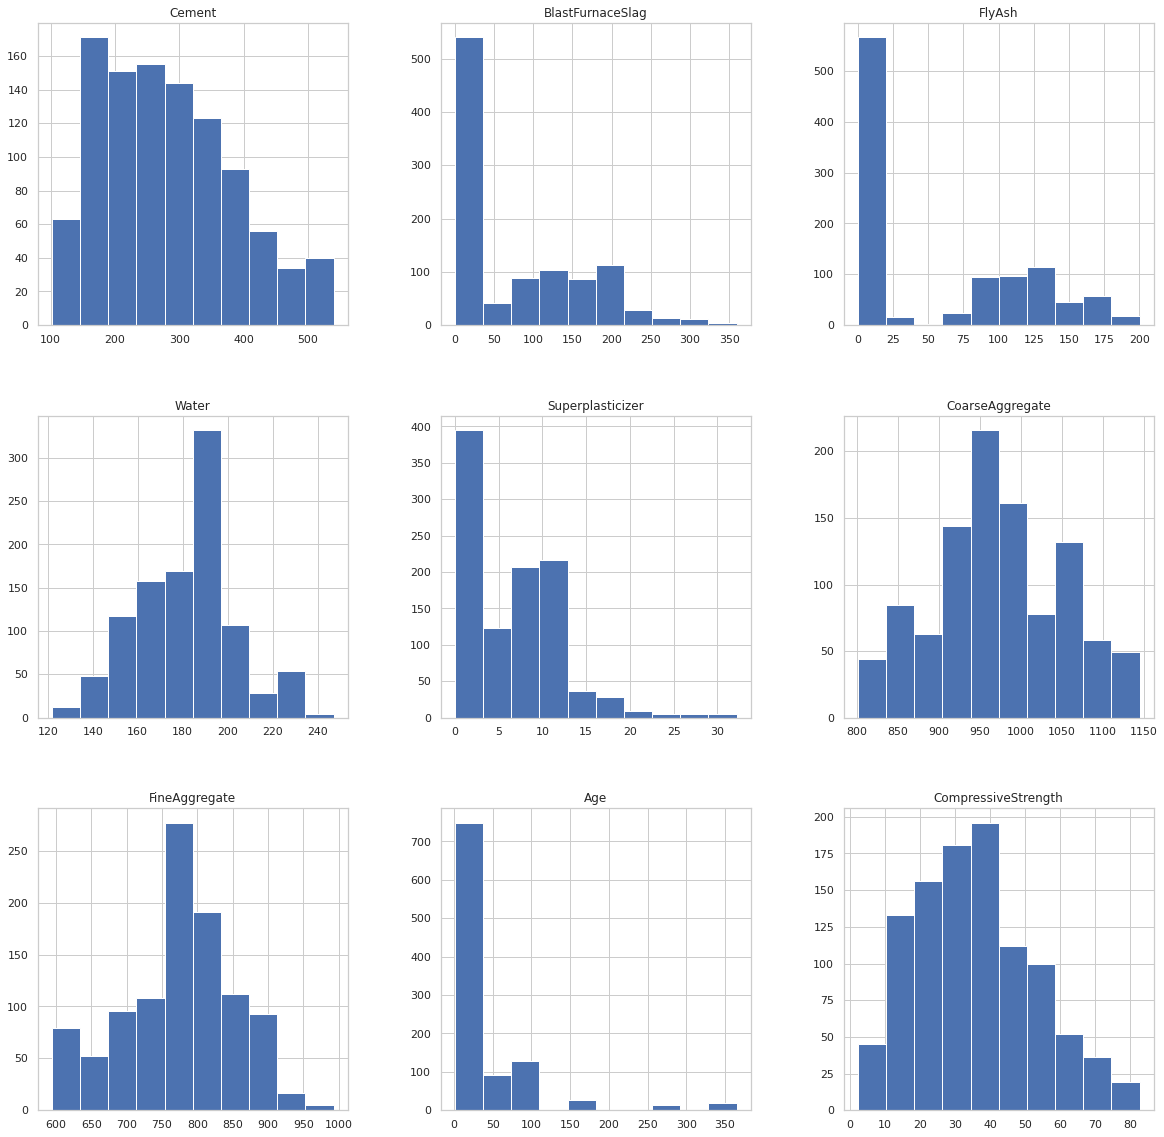

<Figure size 1440x1440 with 0 Axes>

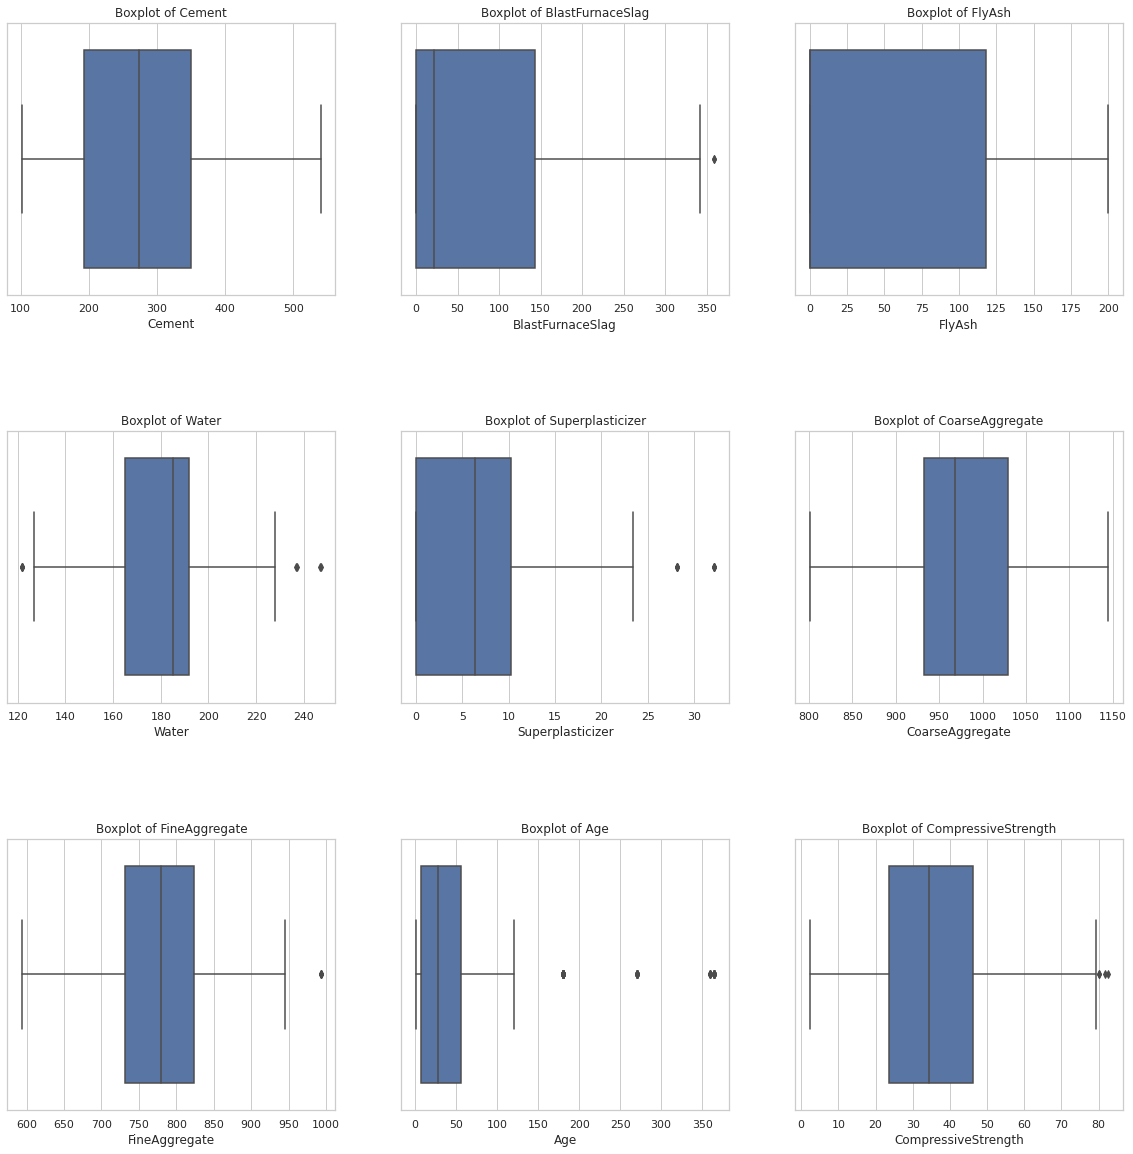

<Figure size 1440x1440 with 0 Axes>

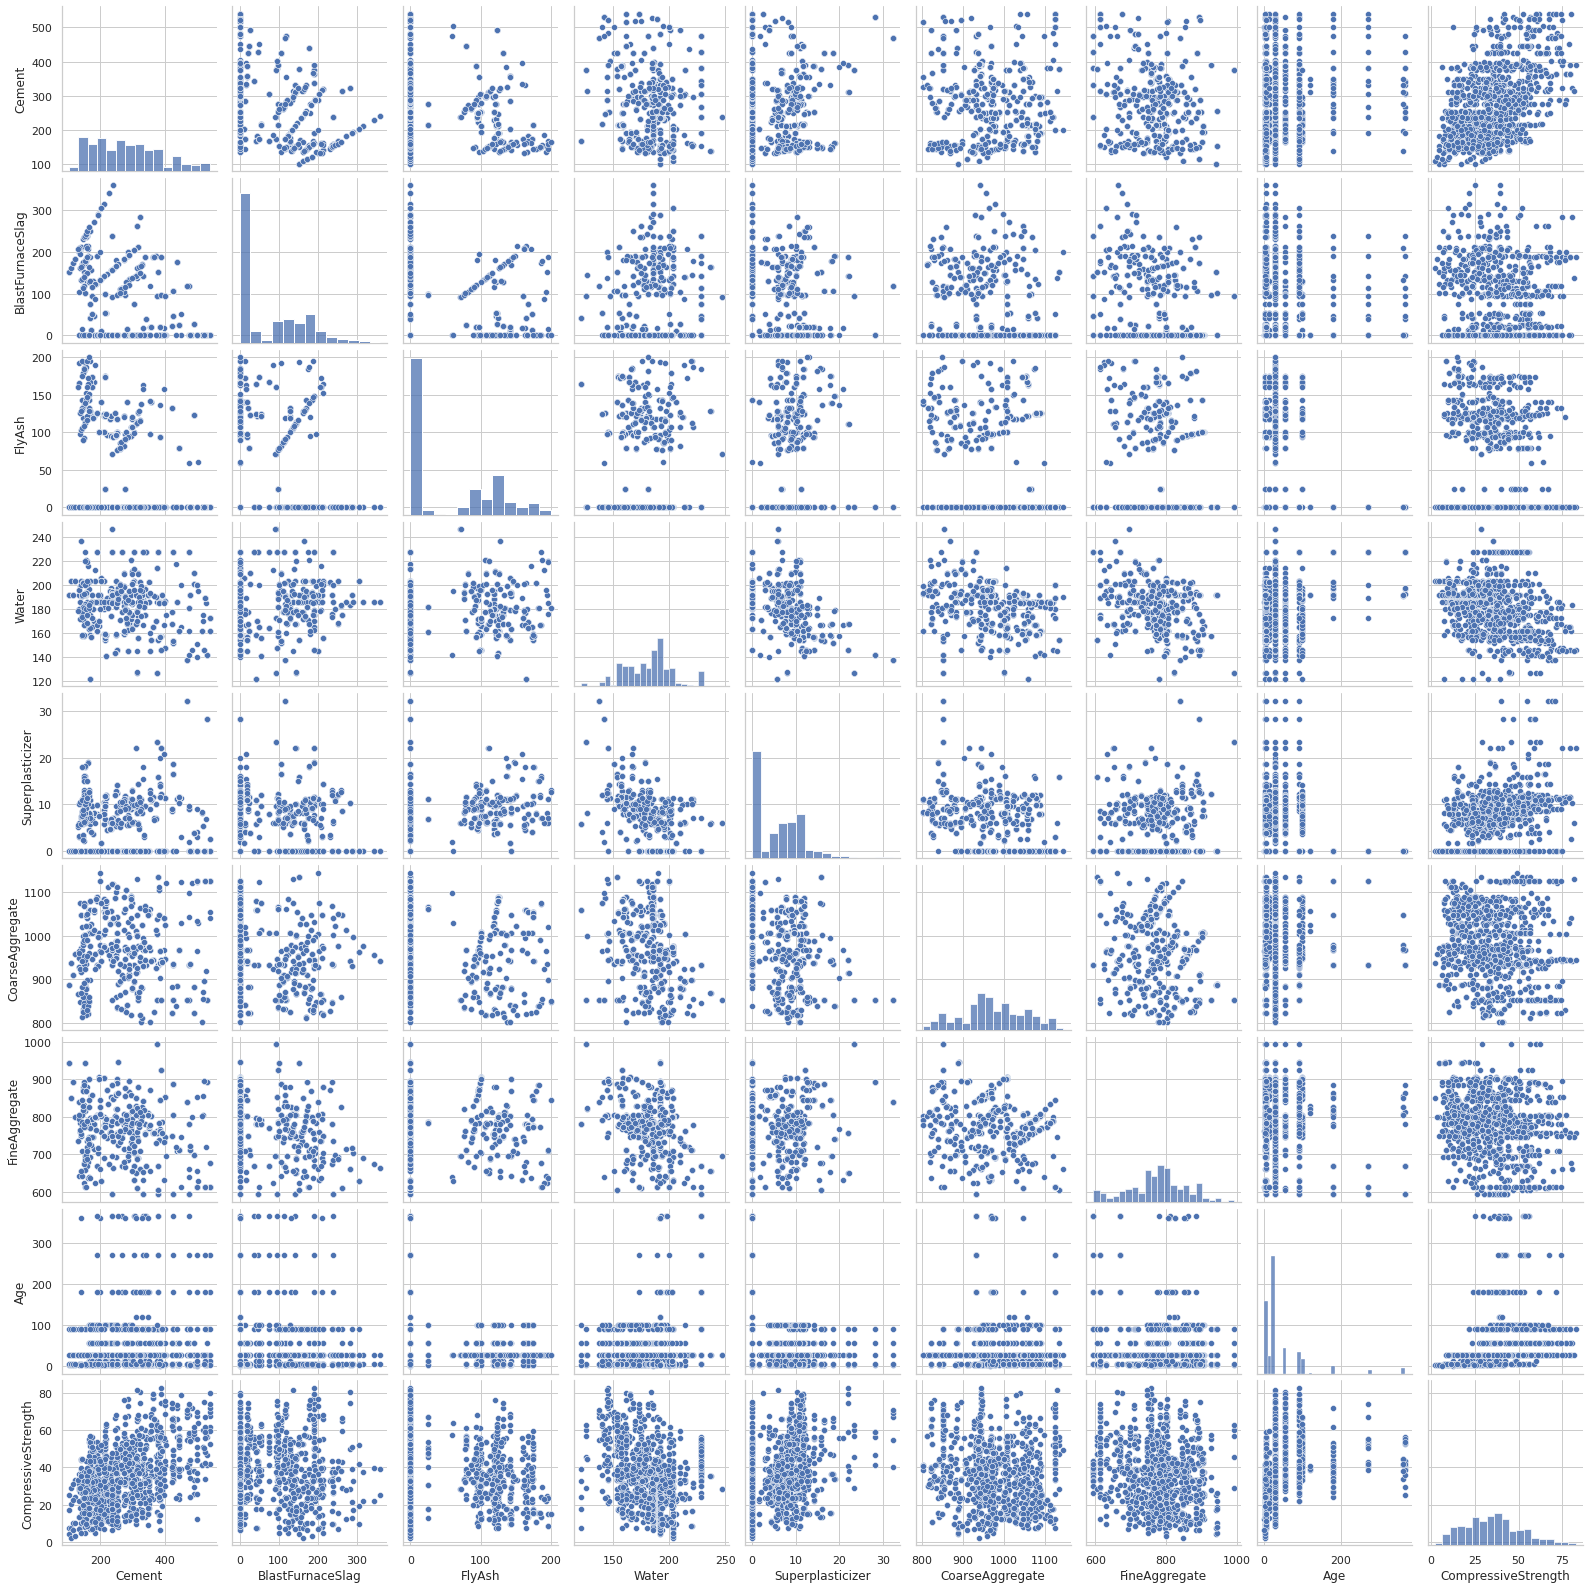

<Figure size 1440x1440 with 0 Axes>

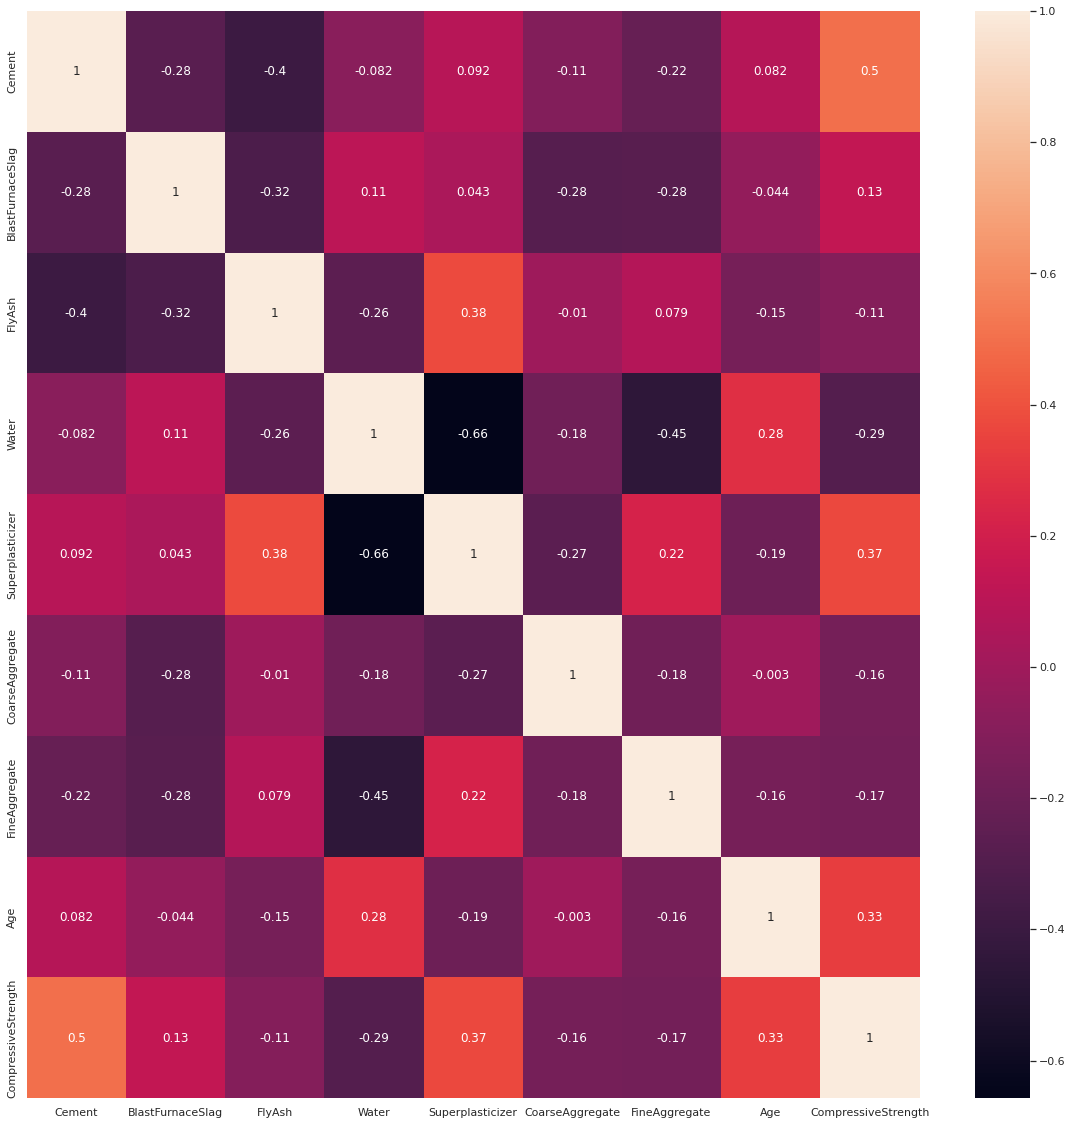

In [23]:
last_fig_number = exploratory_da(dataset)

# Part II, Feature Engineering
In this section, we apply feature engineering techniques to prepare the data set for analysis. The feature engineering techniques are dropping duplicate rows and values. Also, possible outliers are removed using the quantile transform. The qauntile transform transform the dataset to make it have a uniform distribution therby reducing the effects of outliers. Furthermore, the standard scaler is used to make the data have a zero mean and unit variance.

             Cement  BlastFurnaceSlag        FlyAsh        Water  \
count  1.005000e+03      1.005000e+03  1.005000e+03  1005.000000   
mean   2.686629e-16      3.535038e-17  1.979622e-16     0.000000   
std    1.000498e+00      1.000498e+00  1.000498e+00     1.000498   
min   -1.729756e+00     -8.923766e-01 -8.479850e-01    -1.730751   
25%   -8.622980e-01     -8.923766e-01 -8.479850e-01    -0.862721   
50%   -6.926362e-03     -3.567228e-01 -8.479850e-01     0.045479   
75%    8.830691e-01      8.749629e-01  9.013182e-01     0.871593   
max    1.733108e+00      2.082210e+00  2.010991e+00     1.736130   

       Superplasticizer  CoarseAggregate  FineAggregate           Age  \
count      1.005000e+03     1.005000e+03    1005.000000  1.005000e+03   
mean      -3.393637e-16     7.070077e-18       0.000000 -1.767519e-16   
std        1.000498e+00     1.000498e+00       1.000498  1.000498e+00   
min       -1.120016e+00    -1.733882e+00      -1.748735 -1.573179e+00   
25%       -8.511098e-0

<Axes: title={'center': 'Count Plot'}, xlabel='CompressiveStrength', ylabel='count'>

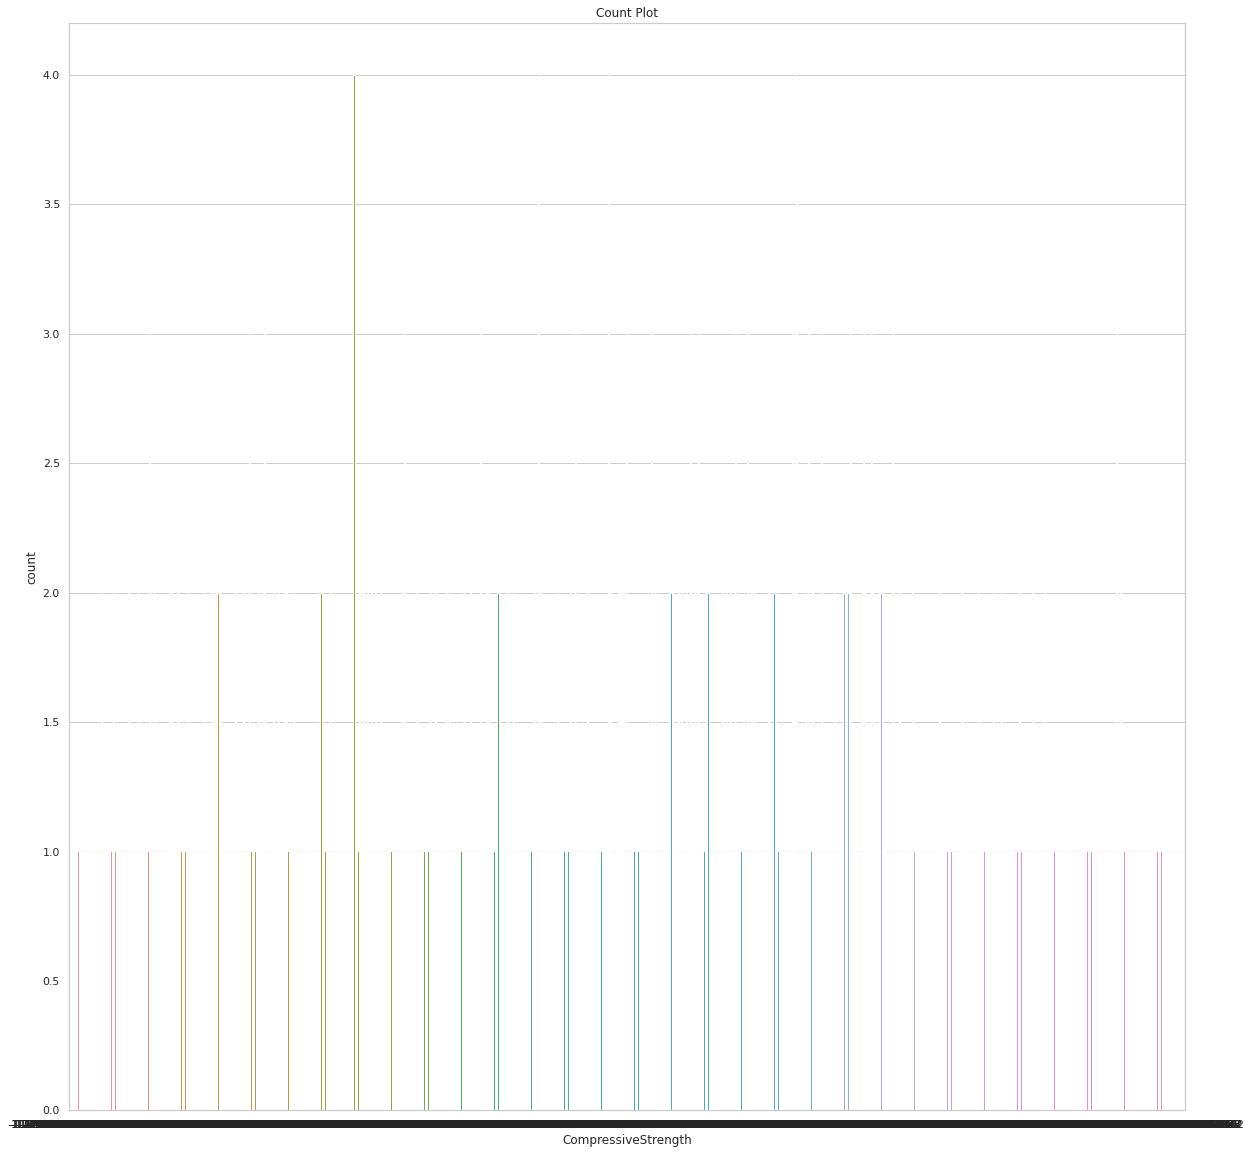

In [44]:
processed_dataset = prepare_dataset(dataset,dataset.columns.tolist(),'CompressiveStrength')
print(processed_dataset.describe())
processed_dataset['CompressiveStrength'].value_counts()
last_fig_number+=1
plt.figure(last_fig_number)
plt.title('Count Plot')
sns.countplot(x='CompressiveStrength',data=processed_dataset)

# III: Model Development
In this section, the dataset is spilt in a 70% - 30% ratio. Then a KNN regressor, random forest, and extreme gradient boost models are built and used to make predictions. Lastly, a voting regressor is used to combine the predictions of the previous models and produce a weighted avergae of their prediction.

In [25]:
# Split dataset, Train - 70%, tEST - 30%
y = processed_dataset['CompressiveStrength']
X = processed_dataset.drop(['CompressiveStrength'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=0)

# KNN Regressor 
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Random Forest Regressor 
rand_for = RandomForestRegressor(n_estimators=100)
rand_for.fit(X_train, y_train)
y_pred_rf = rand_for.predict(X_test)

# Extreme Gradient Boost Algorithm 
xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

ensemble = VotingRegressor([('KNN_Regressor', knn), ('Random_Forest', rand_for), ('Gradient_Boost', xgb)])

ensemble.fit(X_train, y_train)
y_pred_en = ensemble.predict(X_test)


# IV: Model Development II
In this section, various neural networks are developed using keras. The model has an input dimension corresponding to the number of features. Also, the model has 90 and 64 hidden layers. Relu which is thresholding in nature and Sigmoid activation which is smoothing in nature functions are used. Various drop out rates which randomly drop some of the dataset to prevent overfitting are used. As can been seen from the results below, the relu function with a dropout rate of 0.2 had the least mean absolute error.

In [45]:

#####################################
############# Relu ###############
#####################################

model_relu_2 = Sequential()
model_relu_2.add(Dense(90, input_dim=X_train.shape[1], activation='relu'))
model_relu_2.add(Dropout(0.2))
model_relu_2.add(Dense(64, activation='relu'))
model_relu_2.add(Dropout(0.2))
model_relu_2.add(Dense(1, activation='linear'))

model_relu_2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
with open(os.devnull, "w") as f, redirect_stdout(f):  
  model_relu_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=10)

y_pred_relu_2 = model_relu_2.predict(X_test)

model_relu_4 = Sequential()
model_relu_4.add(Dense(90, input_dim=X_train.shape[1], activation='relu'))
model_relu_4.add(Dropout(0.4))
model_relu_4.add(Dense(64, activation='relu'))
model_relu_4.add(Dropout(0.4))
model_relu_4.add(Dense(1, activation='linear'))

model_relu_4.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
with open(os.devnull, "w") as f, redirect_stdout(f):
  model_relu_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=10)

y_pred_relu_4 = model_relu_4.predict(X_test)

model_relu_6 = Sequential()
model_relu_6.add(Dense(90, input_dim=X_train.shape[1], activation='relu'))
model_relu_6.add(Dropout(0.6))
model_relu_6.add(Dense(64, activation='relu'))
model_relu_6.add(Dropout(0.6))
model_relu_6.add(Dense(1, activation='linear'))

model_relu_6.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
with open(os.devnull, "w") as f, redirect_stdout(f): 
  model_relu_6.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=10)

y_pred_relu_6 = model_relu_6.predict(X_test)



#####################################
############# Sigmoid ###############
#####################################

model_sigmoid_2 = Sequential()
model_sigmoid_2.add(Dense(90, input_dim=X_train.shape[1], activation='sigmoid'))
model_sigmoid_2.add(Dropout(0.2))
model_sigmoid_2.add(Dense(64, activation='sigmoid'))
model_sigmoid_2.add(Dropout(0.2))
model_sigmoid_2.add(Dense(1, activation='linear'))


model_sigmoid_2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

with open(os.devnull, "w") as f, redirect_stdout(f):
  model_sigmoid_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=10)

y_pred_sigmoid_2 = model_sigmoid_2.predict(X_test)


model_sigmoid_4 = Sequential()
model_sigmoid_4.add(Dense(90, input_dim=X_train.shape[1], activation='sigmoid'))
model_sigmoid_4.add(Dropout(0.4))
model_sigmoid_4.add(Dense(64, activation='sigmoid'))
model_sigmoid_4.add(Dropout(0.4))
model_sigmoid_4.add(Dense(1, activation='linear'))

model_sigmoid_4.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

with open(os.devnull, "w") as f, redirect_stdout(f):
  model_sigmoid_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=10)

y_pred_sigmoid_4 = model_sigmoid_4.predict(X_test)


model_sigmoid_6 = Sequential()
model_sigmoid_6.add(Dense(90, input_dim=X_train.shape[1], activation='sigmoid'))
model_sigmoid_6.add(Dropout(0.6))
model_sigmoid_6.add(Dense(64, activation='sigmoid'))
model_sigmoid_6.add(Dropout(0.6))
model_sigmoid_6.add(Dense(1, activation='linear'))

model_sigmoid_6.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
with open(os.devnull, "w") as f, redirect_stdout(f):
  model_sigmoid_6.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=10)

y_pred_sigmoid_6 = model_sigmoid_6.predict(X_test)


print(f"Relu 0.2, Mean Absolute Error: {mean_absolute_error(y_test, y_pred_relu_2):.2f}")
print(f"Relu 0.4, Mean Absolute Error: {mean_absolute_error(y_test, y_pred_relu_4):.2f}")
print(f"Relu 0.6, Mean Absolute Error: {mean_absolute_error(y_test, y_pred_relu_6):.2f}")


print(f"Sigmoid 0.2, Mean Absolute Error: {mean_absolute_error(y_test, y_pred_sigmoid_2):.2f}")
print(f"Sigmoid 0.4, Mean Absolute Error: {mean_absolute_error(y_test, y_pred_sigmoid_4):.2f}")
print(f"Sigmoid 0.6, Mean Absolute Error: {mean_absolute_error(y_test, y_pred_sigmoid_6):.2f}")

10/10 [==============================] - 0s 2ms/step
Relu 0.2, Mean Absolute Error: 0.24
Relu 0.4, Mean Absolute Error: 0.29
Relu 0.6, Mean Absolute Error: 0.30
Sigmoid 0.2, Mean Absolute Error: 0.32
Sigmoid 0.4, Mean Absolute Error: 0.34
Sigmoid 0.6, Mean Absolute Error: 0.36


 # Model Comparison, Evaluation 
# Root mean squared error 
Extreme gradient boost model had the lowest root mean squared error. This is expected due the regularization technique it uses (Best). The KNN regressor had the highest RMSE which is expected due to its sensitivity to high varience and poor performance on dataset with complex relationships (Worst).

In [47]:
y_knn_rsme = mean_squared_error(y_test, y_pred_knn,squared=False)
y_rf_rsme = mean_squared_error(y_test, y_pred_rf,squared=False)
y_xgb_rsme = mean_squared_error(y_test, y_pred_xgb,squared=False)
y_relu_2_rsme = mean_squared_error(y_test, y_pred_relu_2,squared=False)

print(f"KNN Regressor: {y_knn_rsme:.2f}")
print(f"Random Forest: {y_rf_rsme:.2f}")
print(f"Gradient Boost: {y_xgb_rsme:.2f}")
print(f"Neural Network: {y_relu_2_rsme:.2f}")

KNN Regressor: 0.44
Random Forest: 0.33
Gradient Boost: 0.32
Neural Network: 0.34


# Mean Absolute Error
The Extreme gradient boosting method had the lowest mean absolute error (Best). While the KNN regressor had the highest mean absolute error (Worst).

In [46]:
y_knn_mae = mean_absolute_error(y_test, y_pred_knn)
y_rf_mae = mean_absolute_error(y_test, y_pred_rf)
y_xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
y_relu_2_mae = mean_absolute_error(y_test, y_pred_relu_2)

print(f"KNN Regressor: {y_knn_mae:.2f}")
print(f"Random Forest: {y_rf_mae:.2f}")
print(f"Extreme Gradient Boost: {y_xgb_mae:.2f}")
print(f"Neural Network: {y_relu_2_mae:.2f}")

KNN Regressor: 0.33
Random Forest: 0.24
Extreme Gradient Boost: 0.21
Neural Network: 0.24


# Mean Squared Error
The extreme gradient boost had the lowest mean squared error (Best) while the KNN regressor had the highest mean squared error (Worst)


In [21]:
y_knn_mse = mean_squared_error(y_test, y_pred_knn)
y_rf_mse = mean_squared_error(y_test, y_pred_rf)
y_xgb_mse = mean_squared_error(y_test, y_pred_xgb)
y_relu_2_mse = mean_squared_error(y_test, y_pred_relu_2)

print(f"KNN Regressor: {y_knn_mse:.2f}")
print(f"Random Forest: {y_rf_mse:.2f}")
print(f"Gradient Boost: {y_xgb_mse:.2f}")
print(f"Neural Network: {y_relu_2_mse:.2f}")

KNN Regressor: 0.19
Random Forest: 0.12
Gradient Boost: 0.10
Neural Network: 0.12


 # R2 Score
 The r2 score shows how well the model fits the data through the variation of the dependent and independent variable. The extreme gradient boost had the highest r2 score (Best) while the KNN regressor had the lowest r2 score (Worst).

In [22]:
y_knn_r2 = r2_score(y_test, y_pred_knn)
y_rf_r2 = r2_score(y_test, y_pred_rf)
y_xgb_r2 = r2_score(y_test, y_pred_xgb)
y_relu_2_r2 = r2_score(y_test, y_pred_relu_2)

print(f"KNN Regressor: {y_knn_r2:.2f}")
print(f"Random Forest: {y_rf_r2:.2f}")
print(f"Gradient Boost: {y_xgb_r2:.2f}")
print(f"Neural Network: {y_relu_2_r2:.2f}")

KNN Regressor: 0.81
Random Forest: 0.88
Gradient Boost: 0.90
Neural Network: 0.88


# Part B, Unsupervised Learning 
In this section, the median, longitude, and latitude features of the housing dataset is analyzed. The Kmeans clustering model is used with 6 clusters. This shows the datapoints clustered to the closest centroid of each cluster.

File found


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-31-c1c9d086bad3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_new["cluster_label"] = k_means.labels_


<Figure size 1440x1440 with 0 Axes>

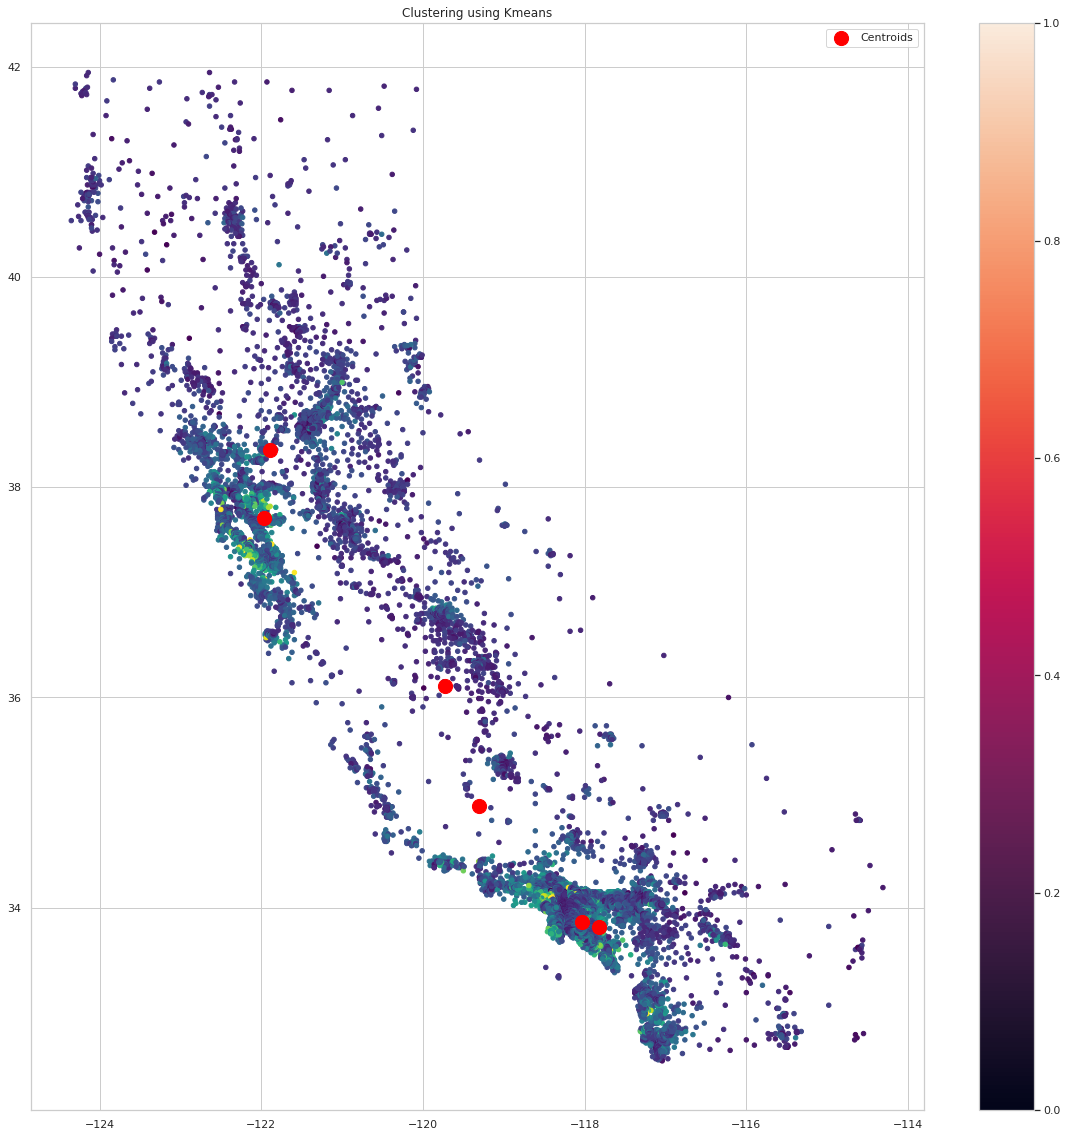

In [31]:
dataset_housing = load_dataset('housing.csv')
features = ['MedInc', 'Longitude', 'Latitude']
dataset_new = dataset_housing[features]
k_means = KMeans(n_clusters=6)
k_means.fit(dataset_new)
dataset_new["cluster_label"] = k_means.labels_

last_fig_number+=1
plt.figure(last_fig_number)
plt.figure(figsize=(20,20))
plt.title("Clustering using Kmeans")
plt.scatter(dataset_new["Longitude"], dataset_new["Latitude"], s=20, c=dataset_new["MedInc"], cmap="viridis")
plt.scatter(k_means.cluster_centers_[:, 1], k_means.cluster_centers_[:, 2], s=200, c='red', marker='o', label='Centroids')
plt.legend()
plt.colorbar()
plt.show()


# Elbow Method to Determine Best K
In this section, the elbow method is used to determine the best number of clusters to cluster the dataset. As can be seen from the figure below, the optimal number of clusters is 6. Also, from the number of clusters vs silhouette coefficient plot, the optimal number of clusters is 3 as it gave a score closest to 1

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

<Figure size 1440x1440 with 0 Axes>

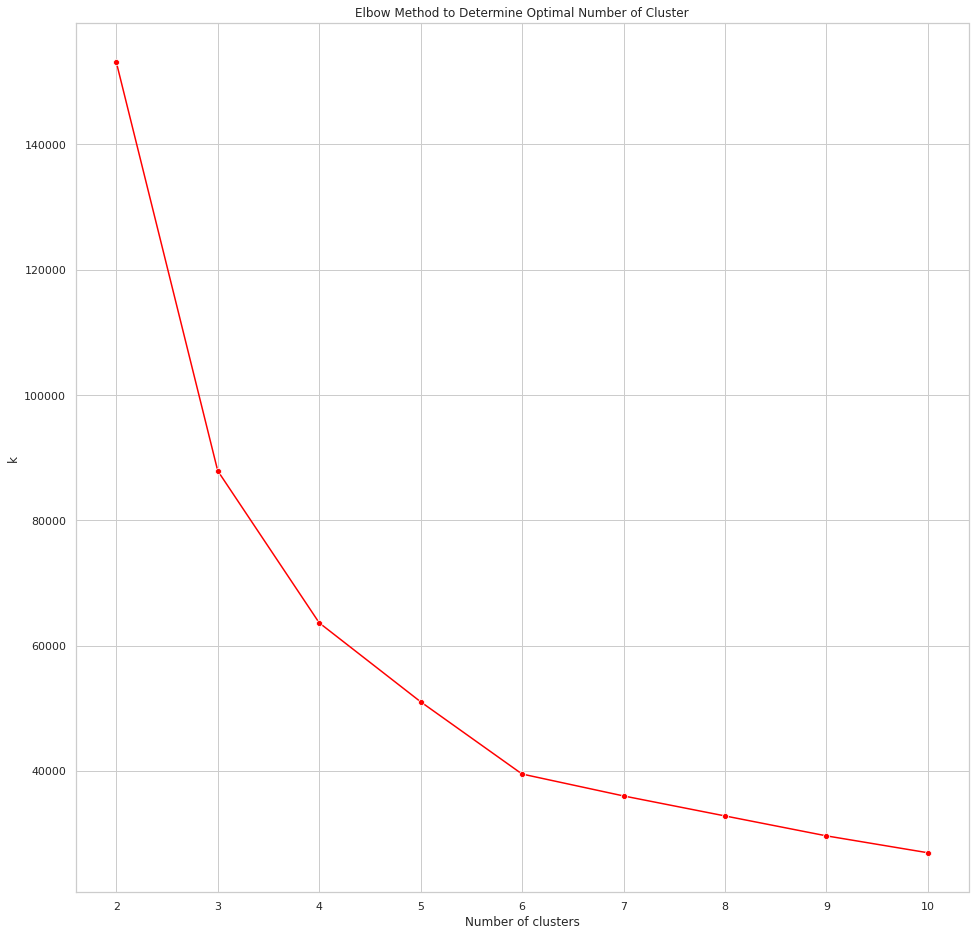

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

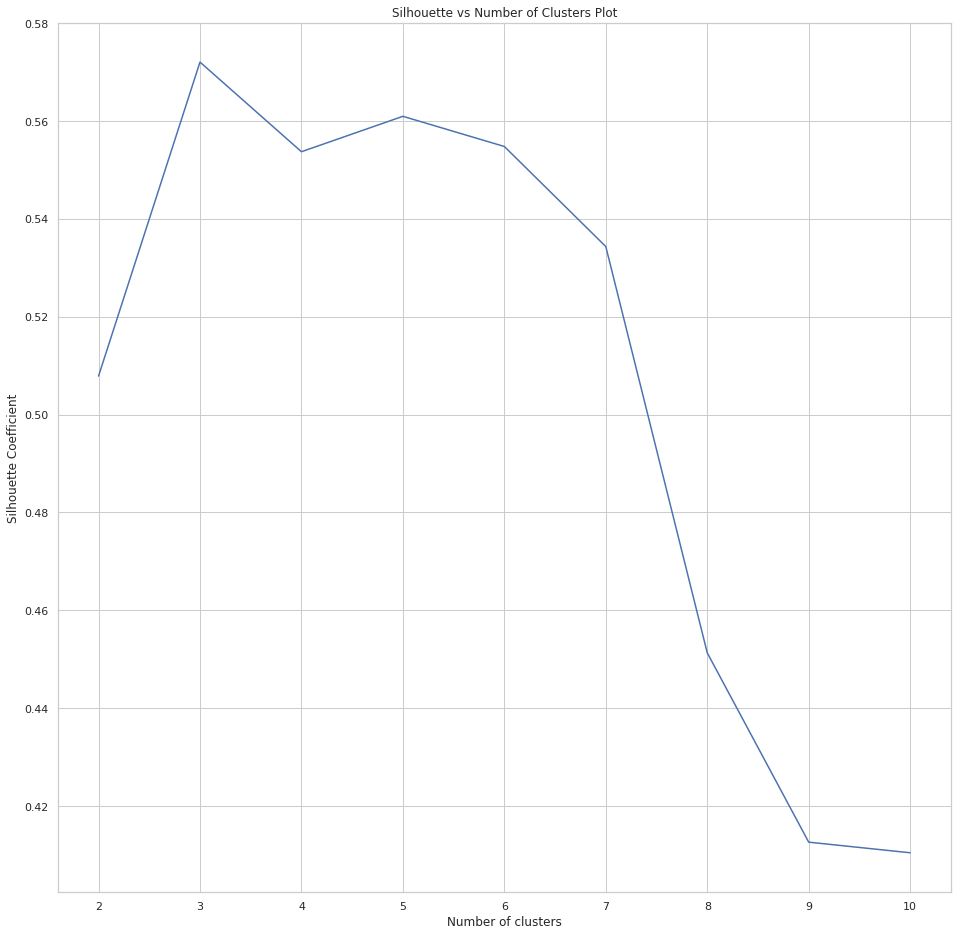

In [37]:
k = []
sil_score = []
with open(os.devnull, "w") as f, redirect_stdout(f):  
  for i in range(2, 11):
      k_means = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
      
      k_means.fit(dataset_new)
      k.append(k_means.inertia_)
      sil_score.append(silhouette_score(dataset_new, k_means.labels_))

last_fig_number+=1
plt.figure(last_fig_number)
plt.figure(figsize=(16,16))
sns.lineplot(x=range(2, 11), y=k, marker='o',color='red')
plt.title('Elbow Method to Determine Optimal Number of Cluster')
plt.xlabel('Number of clusters')
plt.ylabel('k')
plt.show()
plt.subplots_adjust(hspace=0.5)
last_fig_number+=1
plt.figure(last_fig_number)
plt.figure(figsize=(16,16))
plt.plot(range(2, 11),sil_score)
plt.xlabel('Number of clusters')
plt.title('Silhouette vs Number of Clusters Plot')
plt.ylabel('Silhouette Coefficient')
plt.show()